In [31]:
import faiss
import pandas as pd
import torch
from tqdm.notebook import tqdm
import glob 
import pickle
import numpy as np
from random import sample
import os
from collections import OrderedDict 
import csv
from sklearn.metrics import average_precision_score
import math
####################################################
## Select one of the organs: liver |colon | pancreas | lung
organ="pancreas"
## Select one of the aggregation methods: median | maxpooling | avgpooling |std
method = "median"  # median / maxpooling / avgpooling / std
####################################################

## Quantification Files
quantification_dir = r"C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification" 
quantification_csv = r"C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification\2024.02.14.3D_MSD_Annotations.csv"

## Data 
data_splits_folder = r"C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_train_test_split"
if (organ == "pancreas"):
    data_splits_folder = r"C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_train_test_split\pancreas"

# 2D Embeddings 
all_embs_folder = r"C:\Users\ADMIN\Desktop\Workspace\Code\data\embeddings"
test_set_csv =  data_splits_folder + "\\" + organ + "\\" + organ + "_full_test_split.csv"

## Output files 
results_dir = "C:/Users/ADMIN/Desktop/Workspace/Code/BiomedCLIP/MSD-Final/results/results_" + organ
results_eval_metrics = results_dir + "/" + organ + "eval_metrics.csv"

## Index files
train_3d_index_tsv  = r"C:\Users\ADMIN\Desktop\Workspace\Code\BiomedCLIP\MSD-Final\3d-index\pancreas-train-3d-index\faiss_ids_embd_train.tsv"
train_3d_index  = r"C:\Users\ADMIN\Desktop\Workspace\Code\BiomedCLIP\MSD-Final\3d-index\pancreas-train-3d-index\faiss_index_embd_train.index"


In [32]:
class FAISSRetrievalEngine:
    def __init__(self, ids_path, index_path):
        self.ids_path = ids_path
        
        # Load the CSV file without headers and set a default column name
        self.ids = pd.read_csv(self.ids_path, sep="\t", header=None, names=["ids_str"])
        
        # Create a dictionary mapping integers to the string IDs
        self.ids = {i: row["ids_str"] for i, row in self.ids.iterrows()}

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.index_path = index_path
        self.index = faiss.read_index(self.index_path)
        # if self.device == "cuda":
        #     res = faiss.StandardGpuResources()
        #     self.index = faiss.index_cpu_to_gpu(res, 0, self.index)
    
    def _split_array_into_batches(self, arr, batch_size):
        num_rows = arr.shape[0]
        num_batches = (num_rows + batch_size - 1) // batch_size  
        
        # Create a list of batches
        batches = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_rows)
            batch = arr[start_idx:end_idx, :]
            batches.append(batch)

        return batches

    def get_str_ids_from_I(self, I):
        def mapping_fn(x):
            if x in self.ids:
                return self.ids[x]
            else:
                print(f"Index {x} not found in ids dictionary.")
                return None

        return np.vectorize(mapping_fn)(I)

    def retrieve_images_with_3D_emb(self, xq, k=5):
        output_D, output_I = [], []
        D, I = self.index.search(xq, k)
        I_str = self.get_str_ids_from_I(I)
        output_D.append(D)
        output_I.append(I_str)
        return output_D, output_I


index = FAISSRetrievalEngine(
    ids_path=train_3d_index_tsv,
    index_path=train_3d_index
)

**Running the 3D Image Search for all test queries  
**

In [33]:
aggregated_df = pd.read_csv(quantification_csv) 
aggregated_df['name'] = aggregated_df['name'].replace('.nii.gz', '')
for i in range(len(aggregated_df['name'])):
    filename = aggregated_df['name'][i]
    aggregated_df['name'][i] = filename[:filename.index('.')] 
aggregated_df.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8216\748815261.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  aggregated_df['name'][i] = filename[:filename.index('.')]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8216\748815261.py:5: Setting

,name,pancreas_max_tumor_size,number_tumors,pancreas_lesion_group,organ,pancreas_cancer_flag,pancreas_cancer_stage,Relevant query,auto_generated_caption,validate caption (Y/N),Correction if applicable,Relevant case for 3D Image Search,Additional Comments,cancer_stage
0,pancreas_001,5.104953,1,3,pancreas,1,NaN,NaN,"""This 3D volume depicts the pancreas with a si...",NaN,NaN,NaN,NaN,3.0
1,pancreas_004,6.452776,1,4,pancreas,1,NaN,NaN,This is an image of the pancreas with one tumo...,NaN,NaN,NaN,NaN,4.0
2,pancreas_005,3.639289,1,2,pancreas,1,NaN,NaN,This image depicts the pancreas with a single ...,NaN,NaN,NaN,NaN,2.0
3,pancreas_006,4.834758,1,3,pancreas,1,NaN,NaN,This is an image of the pancreas with one tumo...,NaN,NaN,NaN,NaN,3.0
4,pancreas_010,5.667779,1,3,pancreas,1,NaN,NaN,This is an image of the pancreas with one tumo...,NaN,NaN,NaN,NaN,3.0


In [34]:
## Search 
search_results = {'query_img': [], 'results': []}
## Embeddings of the test set 
test_csv = pd.read_csv(test_set_csv)

for img in test_csv['testing']: 
    query_img_id = img[:img.index('.')]
    test_volume_emb = os.path.join(all_embs_folder, query_img_id + '.pkl')
    search_results['query_img'].append(query_img_id)
    with open(test_volume_emb, "rb") as f:
        embd = pickle.load(f)
    emb_3d = []
    if (method == "maxpooling"): 
        emb_3d = np.max(embd, axis=0)
    if (method == "avgpooling"): 
        emb_3d = np.mean(embd, axis=0)
    if (method == "std"): 
        emb_3d = np.std(embd, axis=0)
    if (method == "median"): 
        emb_3d = np.median(embd, axis=0)

    D, I = index.retrieve_images_with_3D_emb(np.array([emb_3d]), 50) ## retrieving 20 volumes
    results = [str(x) for x in I[0][0]]
    resultswoDup = list(OrderedDict.fromkeys(results)) 
    if len(resultswoDup) > 10:
        resultswoDup = resultswoDup[:10]

    search_results['results'].append(resultswoDup)

df = pd.DataFrame(search_results)
df.to_csv(results_dir + '/' + method + '_3d_results.csv', index=False)


In [35]:
## Evaluation

tumor_stage_eval  = {'query': [] } 
tumor_flag_eval = {'query': [] }

for i in range(10):
    tumor_stage_eval[f"Top {i+1}"] = []
    tumor_flag_eval[f"Top {i+1}"] = []

for query, res in zip(search_results['query_img'], search_results['results']):
    query_row = aggregated_df.loc[aggregated_df['name'] == query]

    if query_row.empty:
        print(f"Query '{query}' not found in aggregated_df")
        continue

    query_metrics = query_row.iloc[0]

    tumor_stage_eval['query'].append(query)
    tumor_flag_eval['query'].append(query)

    tumor_flag = organ + "_cancer_flag"
    top_n = res
    
    for k, top_k in enumerate(top_n):
        if k > 9:
            break

        res_row = aggregated_df.loc[aggregated_df['name'] == top_k[:top_k.index('.')]]
        if res_row.empty:
            print(f"Result '{top_k}' not found in aggregated_df")
            tumor_stage_eval[f"Top {k+1}"].append('NA')
            tumor_flag_eval[f"Top {k+1}"].append('NA')
            continue

        res_metrics = res_row.iloc[0]
        # tumor stage
        tumorStage = 0
        if (query_metrics['cancer_stage'] - res_metrics['cancer_stage'] == 0) and (query_metrics['pancreas_lesion_group'] - res_metrics['pancreas_lesion_group'] == 0):
            tumorStage = 1

        tumor_stage_eval[f"Top {k+1}"].append(tumorStage)
        tumor_flag_eval[f"Top {k+1}"].append(1 - abs(query_metrics[tumor_flag] - res_metrics[tumor_flag]))

    if len(top_n) < 10:
        for k in range(len(top_n), 10):
            tumor_stage_eval[f"Top {k+1}"].append('NA')
            tumor_flag_eval[f"Top {k+1}"].append('NA')

tumor_stage_df = pd.DataFrame(tumor_stage_eval)
tumor_stage_df.to_csv(results_dir + '/' + method + '_3d_tumor_stage_eval.csv', index=False) 
tumor_flag_df = pd.DataFrame(tumor_flag_eval)
tumor_flag_df.to_csv(results_dir + '/' + method + '_3d_tumor_flag_eval.csv', index=False)  

In [36]:
## Tumor Flag
print("# Tumor Flag: ")

tumor_flag_df['RowMean'] = tumor_flag_df.iloc[:, 1:4].mean(axis=1)
overall_mean = tumor_flag_df['RowMean'].mean()
print("tumor_flag_p@3: ", '{:.4f}'.format(overall_mean))

tumor_flag_df['RowMean'] = tumor_flag_df.iloc[:, 1:6].mean(axis=1)
overall_mean = tumor_flag_df['RowMean'].mean()
print("tumor_flag_p@5: ", '{:.4f}'.format(overall_mean))

tumor_flag_df['RowMean'] = tumor_flag_df.iloc[:, 1:].mean(axis=1)
overall_mean = tumor_flag_df['RowMean'].mean()
print("tumor_flag_p@10: ", '{:.4f}'.format(overall_mean))

## Tumor Stage
print("# Tumor Stage: ")

tumor_stage_df['RowMean'] = tumor_stage_df.iloc[:, 1:4].mean(axis=1)
overall_mean = tumor_stage_df['RowMean'].mean()
print("tumor_stage_p@3: ", '{:.4f}'.format(overall_mean))

tumor_stage_df['RowMean'] = tumor_stage_df.iloc[:, 1:6].mean(axis=1)
overall_mean = tumor_stage_df['RowMean'].mean()
print("tumor_stage_p@5: ", '{:.4f}'.format(overall_mean))

tumor_stage_df['RowMean'] = tumor_stage_df.iloc[:, 1:].mean(axis=1)
overall_mean = tumor_stage_df['RowMean'].mean()
print("tumor_stage_p@10: ", '{:.4f}'.format(overall_mean))

# Tumor Flag: 
tumor_flag_p@3:  1.0000
tumor_flag_p@5:  1.0000
tumor_flag_p@10:  1.0000
# Tumor Stage: 
tumor_stage_p@3:  0.4881
tumor_stage_p@5:  0.5214
tumor_stage_p@10:  0.5409


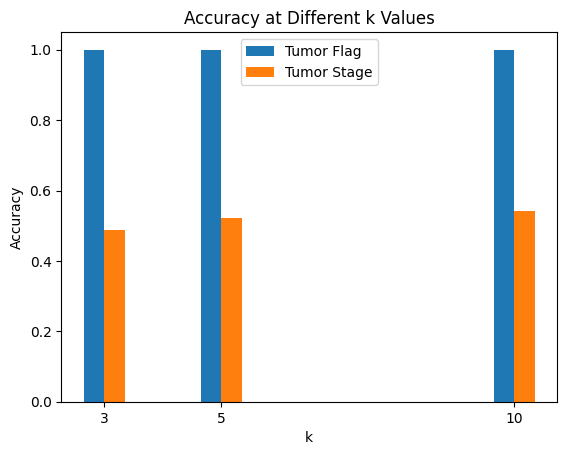

In [37]:
import matplotlib.pyplot as plt

# Accuracy values for tumor flag and tumor stage
k_values = [3, 5, 10]
tumor_flag_accuracy = [1.0000, 1.0000, 1.0000]
tumor_stage_accuracy = [0.4881, 0.5214, 0.5409]

# Create the bar plot
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Plot tumor flag accuracy
ax.bar([x - width/2 for x in k_values], tumor_flag_accuracy, width, label='Tumor Flag')

# Plot tumor stage accuracy
ax.bar([x + width/2 for x in k_values], tumor_stage_accuracy, width, label='Tumor Stage')

# Adding labels and title
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy at Different k Values')
ax.set_xticks(k_values)
ax.legend()

# Show the plot
plt.show()


## Average Precision

In [38]:
ref_tumor_flag = []
all_res_tumor_flag = []
ref_tumor_stage = []
all_res_tumor_stage = []

for query, res in zip(search_results['query_img'], search_results['results']):
    query_metrics = aggregated_df.loc[aggregated_df['name'] == query].iloc[0]
    tumor_flag = organ + "_cancer_flag" 
    ref_tumor_flag.append(query_metrics[tumor_flag])
    ref_tumor_stage.append(query_metrics['cancer_stage'])
    top_n = res
    res_tumor_flag = []
    res_tumor_stage = []
    for k, top_k in enumerate(top_n):
        if k > 9:
            break
        res_metrics = aggregated_df.loc[aggregated_df['name'] == top_k[:top_k.index('.')]].iloc[0]
        res_tumor_flag.append(res_metrics[tumor_flag])
        res_tumor_stage.append(res_metrics['cancer_stage'])
    all_res_tumor_flag.append(res_tumor_flag)
    all_res_tumor_stage.append(res_tumor_stage)

## Adaptation for Average Precision (AP) computation
## AP - Tumor Flag
for i, q in enumerate(ref_tumor_flag):
    if q == 0:
        for j, res in enumerate(all_res_tumor_flag[i]):
            if res == 0:
                all_res_tumor_flag[i][j] = 1
            else:
                all_res_tumor_flag[i][j] = 0

## AP - Tumor Stage
for i, q in enumerate(ref_tumor_stage):
    print(q)
    for j, res in enumerate(all_res_tumor_stage[i]):
        if res == q:
            all_res_tumor_stage[i][j] = 1
        else:
            all_res_tumor_stage[i][j] = 0
            

1.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
3.0
3.0
3.0
3.0
3.0
3.0


In [39]:
##############
## Tumor Flag
##############

ref_tumor_flag = np.array(ref_tumor_flag)
all_res_tumor_flag = np.array(all_res_tumor_flag)

ap = 0
for i, q in enumerate(ref_tumor_flag):
    
    try:
        flag_avg_precision =  average_precision_score(all_res_tumor_flag[i], list(range(len(all_res_tumor_flag[i])))[::-1])
        
        if math.isnan(flag_avg_precision):
            flag_avg_precision=0

        ap = ap + flag_avg_precision
    except:
        print(all_res_tumor_flag[i])

print("flag_avg_precision: ", '{:.4f}'.format(ap/len(ref_tumor_flag)))


flag_avg_precision:  1.0000


In [40]:
###############
## Tumor Stage
###############

ref_tumor_stage = np.array(ref_tumor_stage)
all_res_tumor_stage = np.array(all_res_tumor_stage)
ap = 0

for i, q in enumerate(ref_tumor_stage):
    
    try:
        stage_avg_precision =  average_precision_score(all_res_tumor_stage[i], list(range(len(all_res_tumor_flag[i])))[::-1])
        
        if math.isnan(stage_avg_precision):
            stage_avg_precision=0
        
        ap = ap + stage_avg_precision
    except:
        print(all_res_tumor_stage[i])

print("stage_avg_precision: ", '{:.4f}'.format(ap/len(ref_tumor_stage)))


stage_avg_precision:  0.6180


c:\Users\ADMIN\Desktop\Workspace\Code\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
